# Extract and Enhance Velocity Changes 

This notebook:

1) Strecth DAS ACFs for dV/V likelihood

2) Denoise dV/V likelihood and get clean dV/V

In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import h5py

import sys
sys.path.append("./src")
from das_util import get_tstamp, calc_NFFT
from das_util import stretch, stretch_distribution, fk_filter_2cones

import numpy as np
import pandas as pd

import scipy
import scipy.signal as sgn
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.interpolate import interp1d, RegularGridInterpolator
from obspy import UTCDateTime
from tqdm import tqdm

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

# Data 

## Data 1 --ACF and raw waveform from server

In [2]:
### ACF file is big, stored on server
with h5py.File('data/autocorr_15_60Hz_stretchedx2.hdf5', 'r') as f:
    corr_all_time = f['autocorr'][:]
corr_all_time.shape

(50, 482, 4349)

In [3]:
# %% Raw data is big, stored on server
datah5 = '/fd1/QibinShi_data/England_farm/farmDAS_harper_0_36hr.hdf5'
with h5py.File(datah5, 'r') as f:
    full_time_data_h5 = f["data"][:]
    sample_rate_h5 = f["dt"][()]
    time_stamp_h5 = f["timestamp"][:]
full_time_data = full_time_data_h5
sample_rate = sample_rate_h5
acqu_time = np.array([UTCDateTime(i) for i in time_stamp_h5])

## Data 2 --DAS PSD from server

51 channels, 2408 time segments, 129 frequency points

In [4]:
### Here is how the PSD data was saved
# with h5py.File('/fd1/QibinShi_data/England_farm/psd_all.hdf5', 'w') as f:
#     f.create_dataset("psd_all_time", data=PSD_all_time)
#     f.create_dataset("frequency", data=freq)
#     f.create_dataset("daslist", data=file_list.astype('S'), dtype='S100')

with h5py.File('/fd1/QibinShi_data/England_farm/psd_all.hdf5', 'r') as f:
    file_list = f['daslist'][:].astype('U')
    PSD_all_time = f['psd_all_time'][:]
    freq = f['frequency'][:]
    
acqu_time = np.array([get_tstamp(i) for i in file_list])
start_file = np.arange(0, len(acqu_time), 5)
time_stamps = acqu_time[start_file]

## Mean PSD over channels
ave_psd=np.mean(np.sum(PSD_all_time[0:44, :, 52:90], axis=-1) * (freq[1]-freq[0]), axis=0)

## Index on the hour
hourly_index = [67,127,187,247,299,359,419,466,526,586,646,706,766,826,886,946,1003,1063,1123,
         1183,1243,1302,1362,1422,1482,1542,1599,1659,1719,1779,1839,1899,1959,2019,
         2078,2138,2198,2258,2318]

## smoothing over 1 hr window
hr_psd=[]
for ind in hourly_index:
    st_ind = int(ind - 60)
    ed_ind = st_ind + 60
    hr_psd.append(np.sum(ave_psd[st_ind:ed_ind]))

Ind6hrs = [7, 359, 706, 1063, 1422, 1779, 2138]
for i in Ind6hrs:
    print(acqu_time[i])

2023-03-17T18:00:00.000000Z
2023-03-18T00:00:00.000000Z
2023-03-18T06:00:00.000000Z
2023-03-18T12:00:00.000000Z
2023-03-18T18:00:00.000000Z
2023-03-19T00:00:00.000000Z
2023-03-19T06:00:00.000000Z


## Data 3 -- Soil measurements (local folder)

In [5]:
csv_file = pd.read_csv('data/NewportSalop_merged.csv', low_memory=False).dropna(axis='columns', how='all')
## Index for soil measurements
j = 32
# print(csv_file['Time'][j:j+40])

humidity=csv_file['Humidity'][j+1:j+40].to_numpy()
soil_temp_10=csv_file[' 10cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_30=csv_file['30cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_100=csv_file['100cm Soil Temperature'][j+1:j+40].to_numpy()
rainfall=csv_file[' Rainfall Total since 0900'][j:j+40].to_numpy()
rain_diff=np.diff(rainfall)

air_temp = csv_file['Dry Bulb Temperature'][j+1:j+40].to_numpy()
dew_temp = csv_file['Dew Point Temperature'][j+1:j+40].to_numpy()
grs_temp = csv_file['Grass Temperature'][j+1:j+40].to_numpy()

# Stretch

In [6]:
freqmin=15
freqmax=60
samp_freq = 500
dchan = 3.19
win_st = int(0.012*samp_freq)
stretch_range = np.arange(0.85, 1.15, 0.01)

x=np.arange(corr_all_time.shape[1])
y=np.arange(corr_all_time.shape[2])
xax=np.arange(0, x.shape[-1], 48)
tax=acqu_time[:2410:240]
time = y[win_st:] / samp_freq
hrax=[dt.strftime('%d %H:%M') for dt in tax]


## Stretch 1 --using mean ACF to stretch, and stack for a reference ACF

In [7]:
stack_stretch=np.zeros((50, len(time)), dtype = np.float32)

for iloc in range(50):
    data_plot=corr_all_time[iloc].T
    trunc_acf = data_plot[win_st:, :]
    trunc_stk = np.mean(trunc_acf, axis=1)
    
    count = 0
#     plt.figure(figsize = (10, 3), dpi = 200)
    for i in x[::5]:
        tmp=np.zeros_like(time)
        stretched, time_new, ratio, cc = stretch(trunc_stk, trunc_acf[:,i], time, min_ratio=0.85, max_ratio=1.15)
        if cc > 0.5:  # stack
            length=min(len(stretched), len(time))
            tmp[:length]=stretched[:length]
            stack_stretch[iloc, :] += tmp
#             plt.plot(time, tmp)
            count +=1
        else:continue
#     plt.plot(time, stack_stretch[iloc, :]/count, c='k', lw=9, alpha=0.5, label='mean of all')
#     plt.title('channel '+ str(iloc+44)); plt.legend(); plt.xlabel('lag time (s)')

Two examples: dvv distribution 

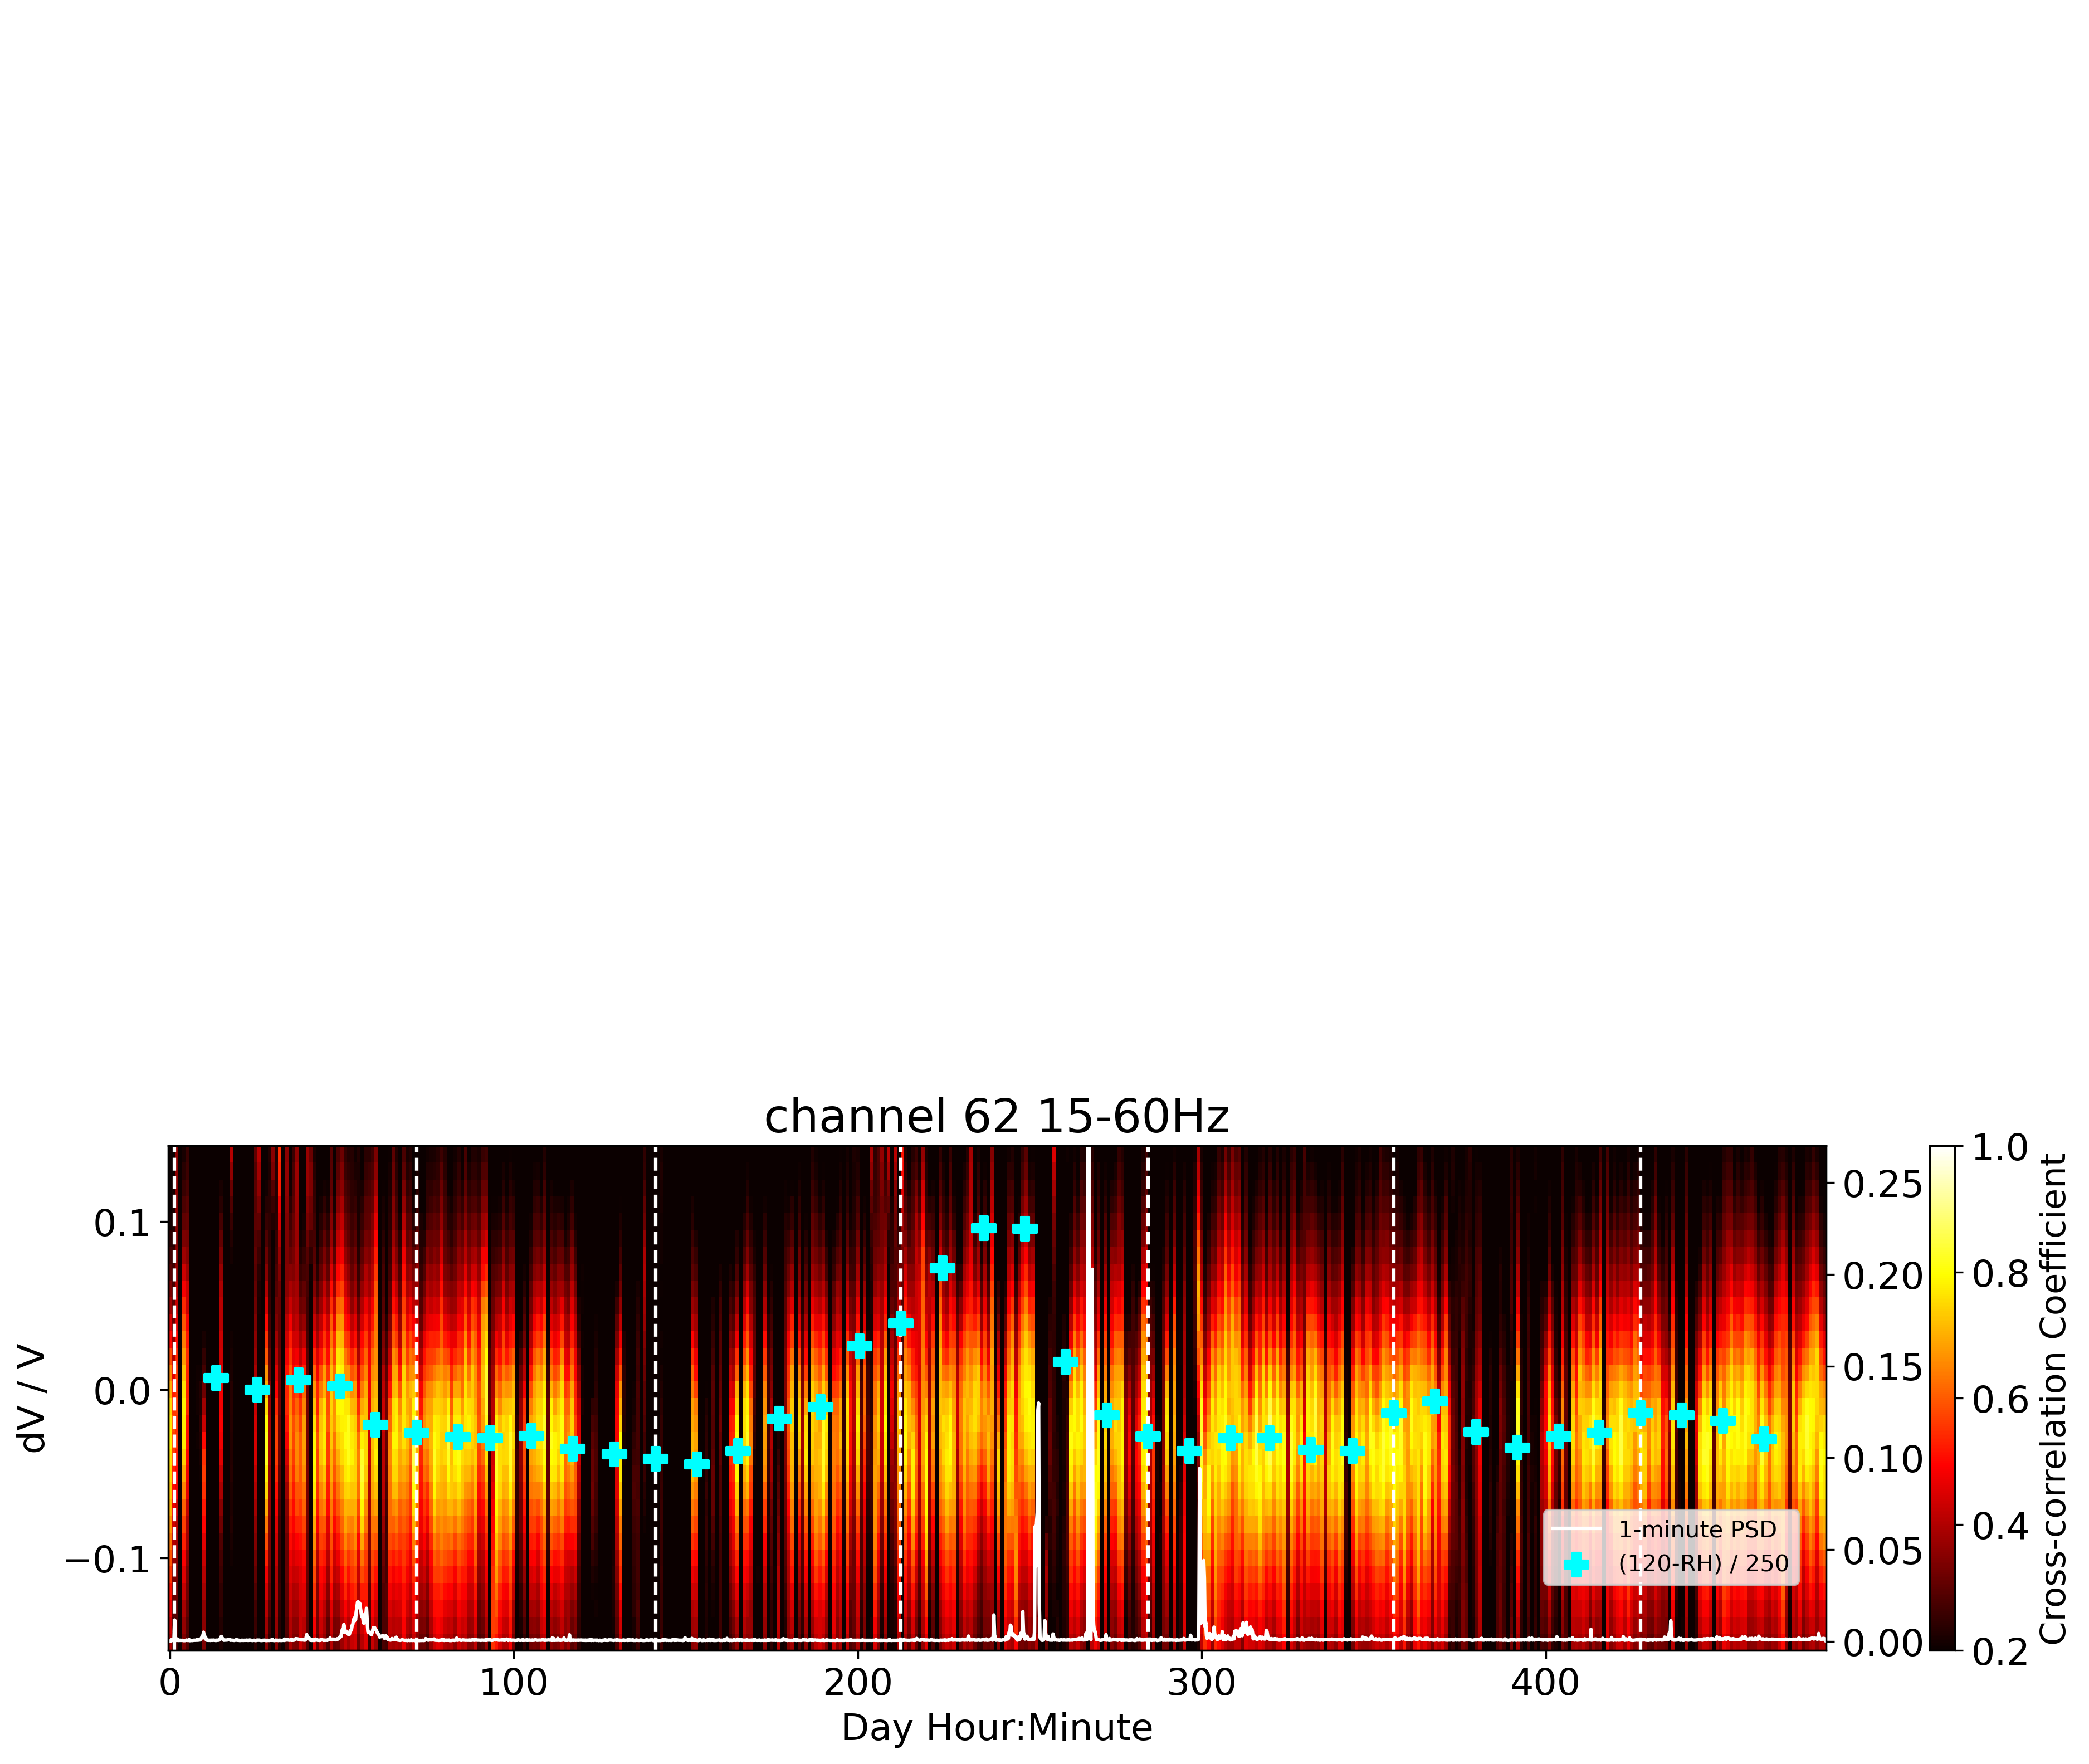

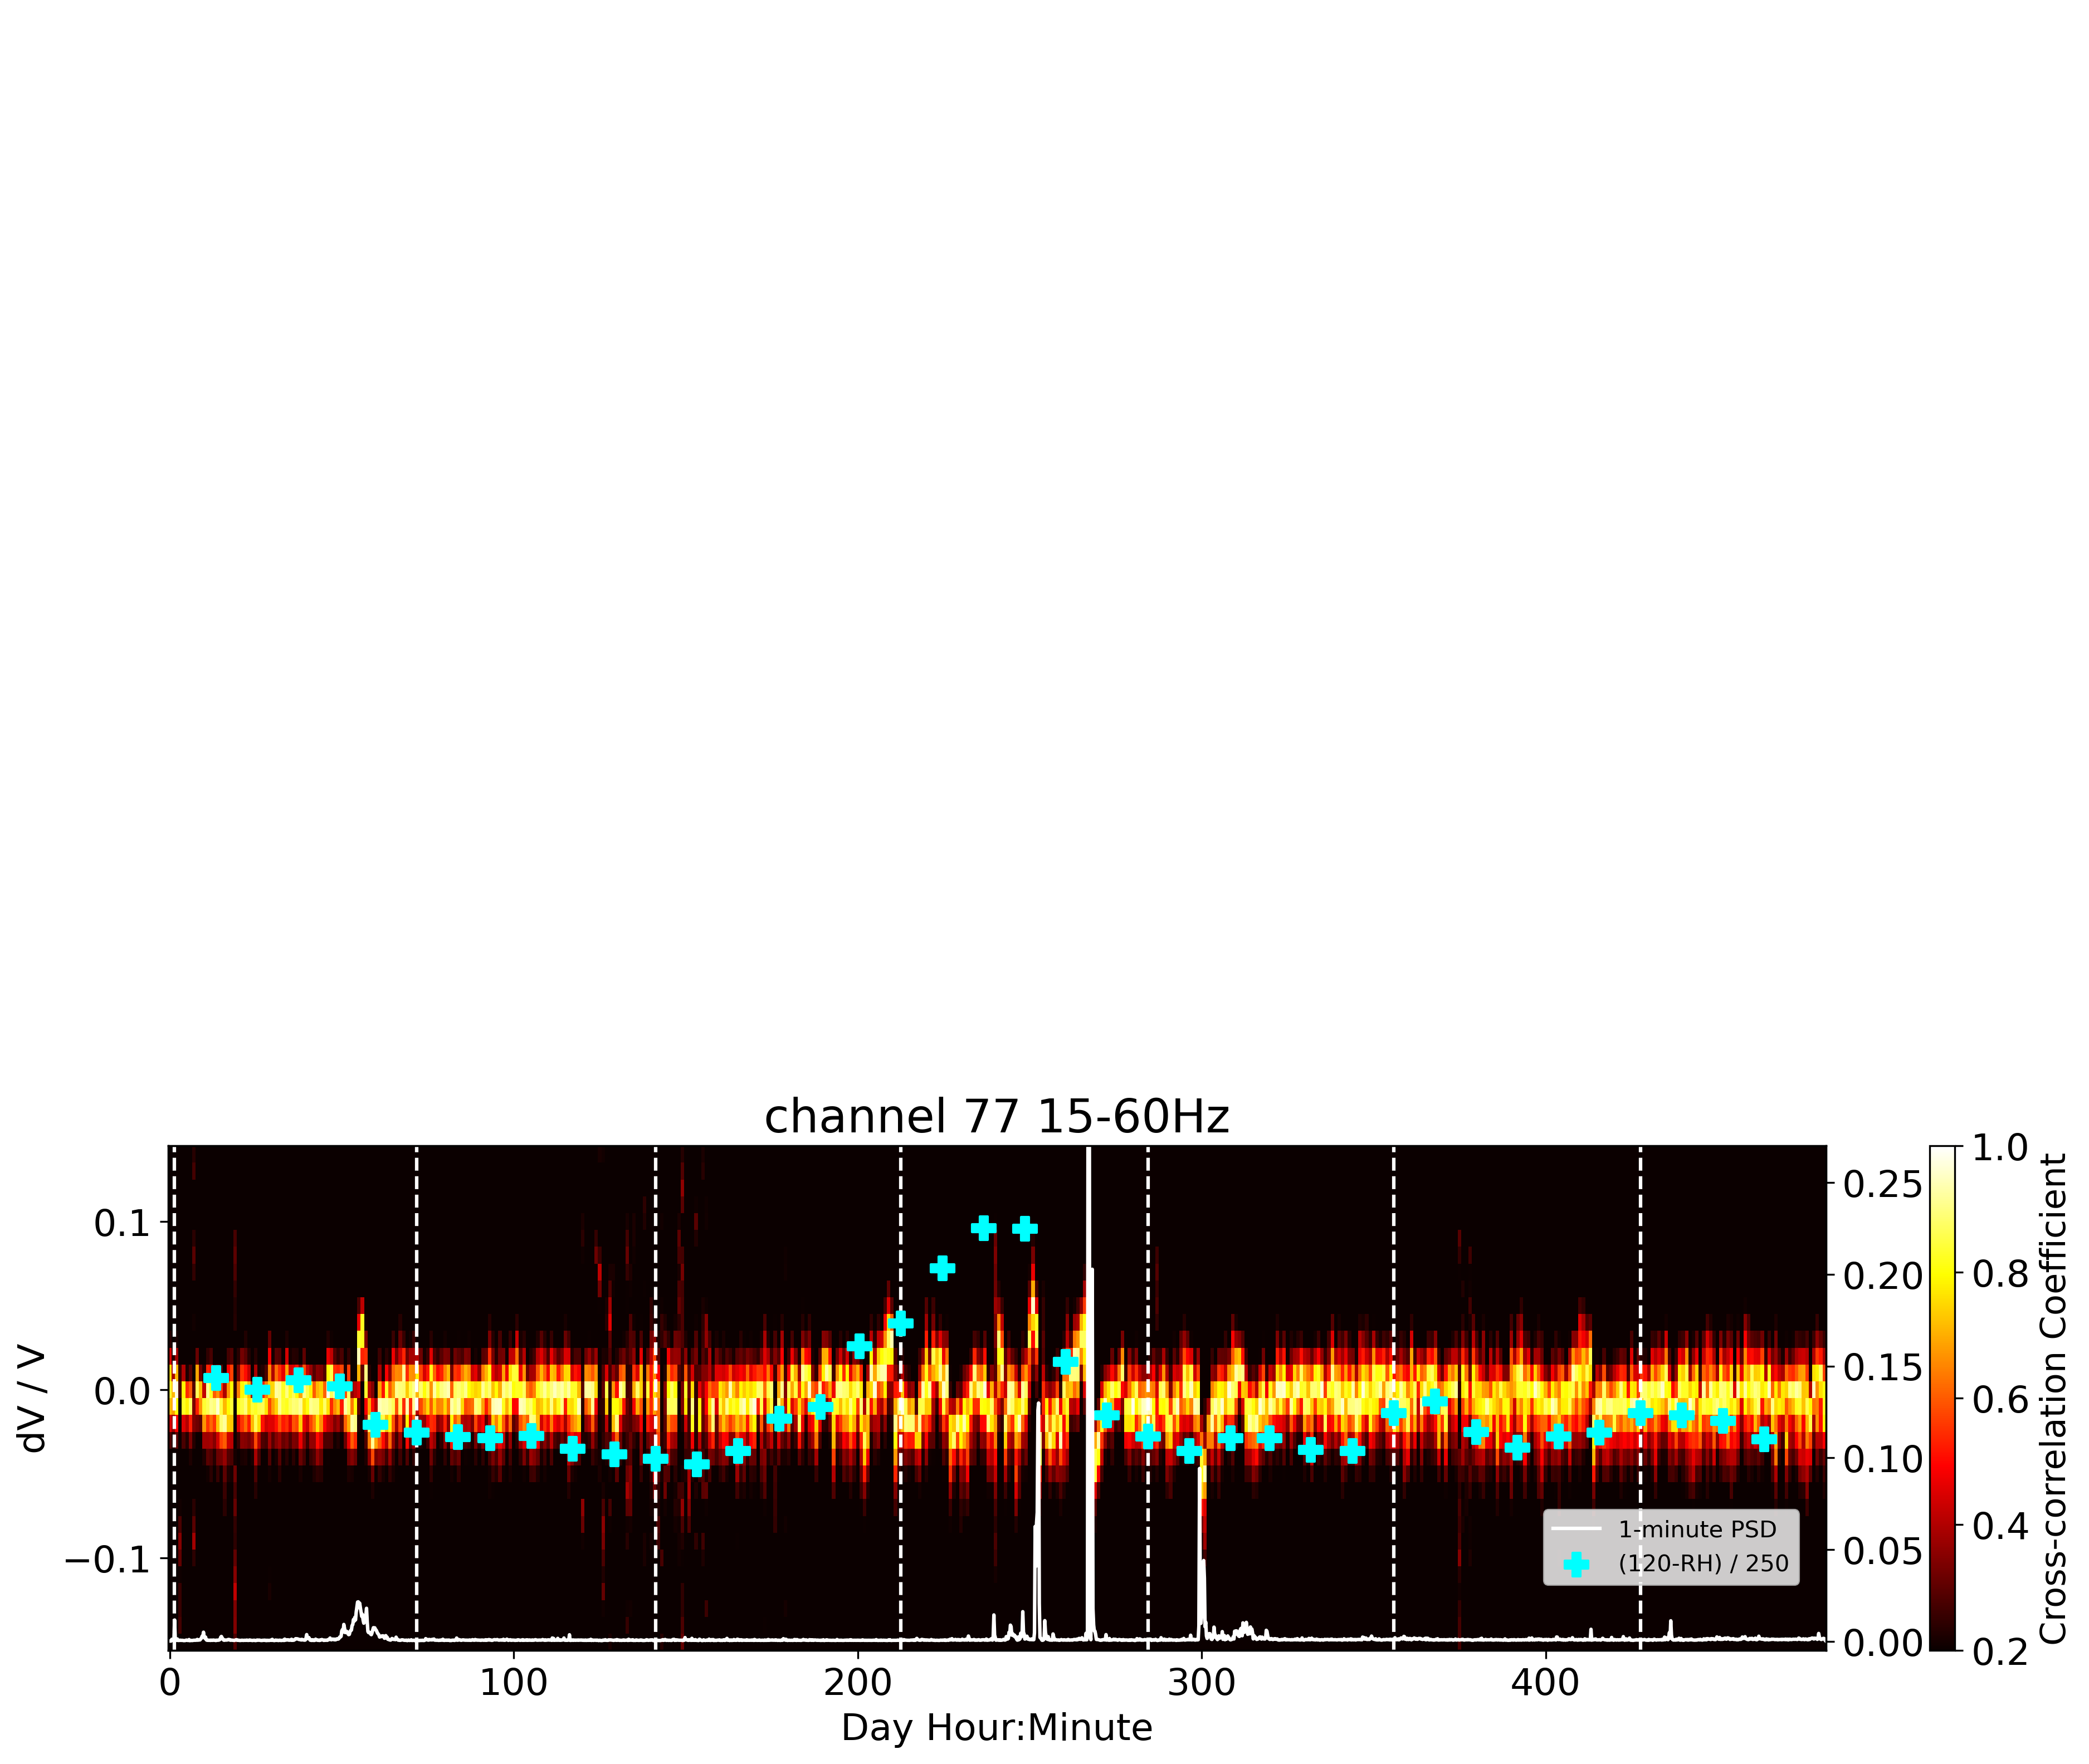

In [8]:
all_cc = np.zeros((50, len(stretch_range), len(x)), dtype = np.float32)

for iloc in [18, 33]:
    data_plot=corr_all_time[iloc].T
    trunc_acf = data_plot[win_st:, :]
    trunc_stk = stack_stretch[iloc, :]/count
    strecthed_acfs = np.zeros_like(trunc_acf)
    for i in x:
        ratios, ccs = stretch_distribution(trunc_stk, trunc_acf[:,i], time, min_ratio=0.85, max_ratio=1.15)
        all_cc[iloc, :, i] = ccs  
    plt.figure(figsize = (16, 4), dpi = 300)
    plt.pcolormesh(x, stretch_range-1, all_cc[iloc], shading='auto', vmin=0.2, vmax=1, cmap = 'hot')
    plt.xlabel("Day Hour:Minute", fontsize = 16)
    plt.ylabel("dV / V", fontsize = 16)

    plt.title('channel '+ str(iloc+44)+ ' ' + str(freqmin)+'-'+str(freqmax)+'Hz', fontsize = 20)
    bar = plt.colorbar()
    bar.set_label('Cross-correlation Coefficient', fontsize = 15)
    for it in Ind6hrs:
        plt.axvline(x = it/5, color = 'w', linestyle='--')
    plt.text(Ind6hrs[0]/5, 0.8, '6 pm', color='w')
    plt.text(Ind6hrs[1]/5, 0.8, '12 am', color='w')
    plt.text(Ind6hrs[2]/5, 0.8, '6 am', color='w')
    plt.text(Ind6hrs[3]/5, 0.8, '12 pm', color='w')
    plt.text(Ind6hrs[4]/5, 0.8, '6 pm', color='w')
    plt.text(Ind6hrs[5]/5, 0.8, '12 am', color='w')
    plt.text(Ind6hrs[6]/5, 0.8, '6 am', color='w')

    
    axcopy = plt.twinx()
    axcopy.scatter(np.array(hourly_index)/5, (120-humidity)/250, label='(120-RH) / 250', color='cyan', marker='P', s=100)
#     axcopy.scatter(np.array(hourly_index)/5, soil_temp_10-7.5, label='T_10cm', color='w', marker='^')
#     axcopy.scatter(np.array(hourly_index)/5, (soil_temp_30-7.5), label='T_30cm', color='w', marker='s')
#     axcopy.scatter(np.array(hourly_index)/5, (soil_temp_100-7.5), label='T_100cm', color='w', marker='v')
#     axcopy.scatter(np.array(hourly_index)/5, rain_diff/3.5, label='1-hour rainfall', color='g', marker='o', s=100)
#     axcopy.scatter(np.array(hourly_index)/5, np.array(hr_psd), label='1-hour PSD', color='b', marker='*', s=100)
#     axcopy.plot(np.array(hourly_index)/5, np.array(hr_psd))
    axcopy.plot(np.arange(ave_psd.shape[-1])/5, ave_psd, label='1-minute PSD', color='w')
    axcopy.legend(fontsize = 10, loc=(0.83,0.13))
    axcopy.set_ylim(-0.005,0.27)
    # plt.savefig('dvv_rain_moisture_ch'+str(iloc)+'.png')

## Stretch 2 --use the reference ACF to stretch, and denoise to for initial dV/V

<ipython-input-9-b4c70f9bb378>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (12, 2))


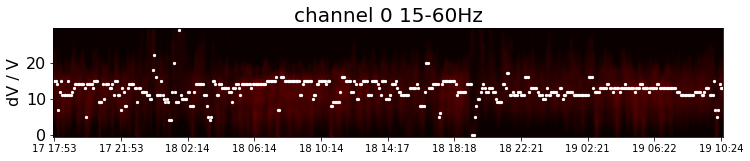

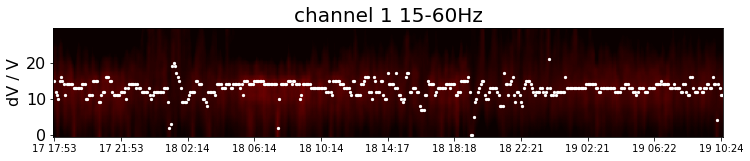

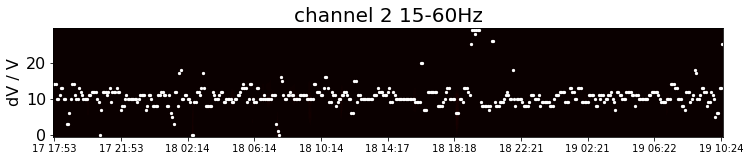

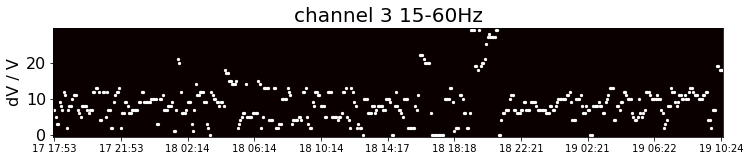

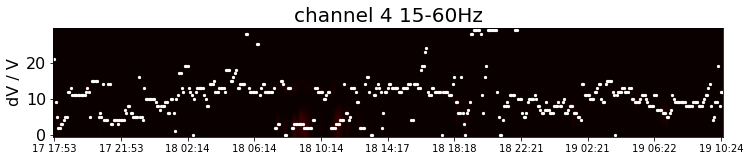

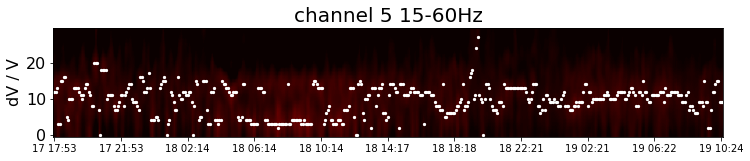

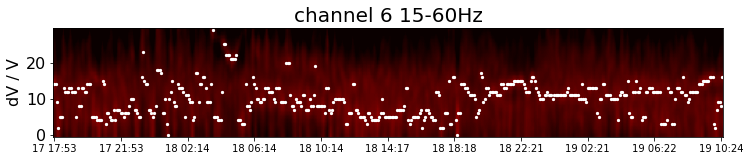

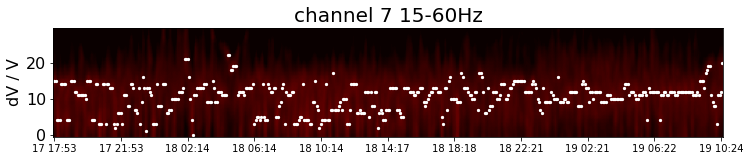

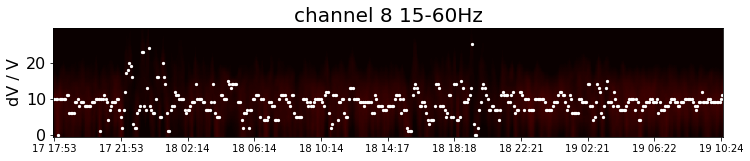

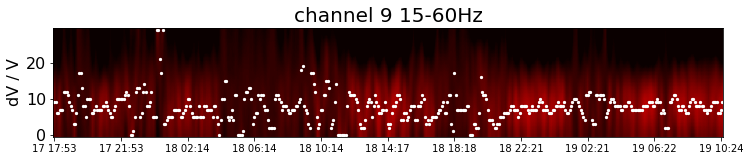

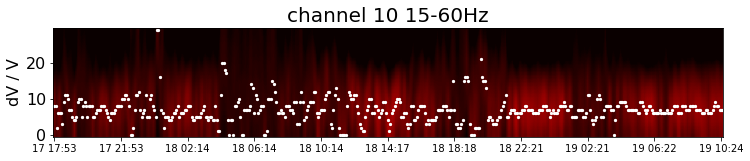

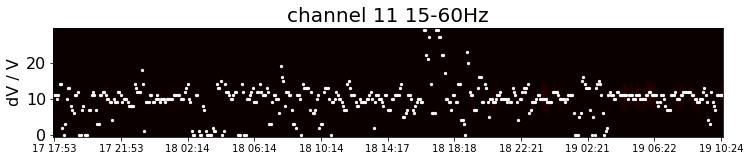

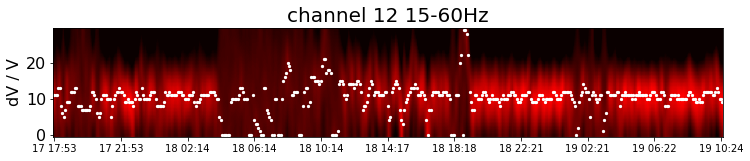

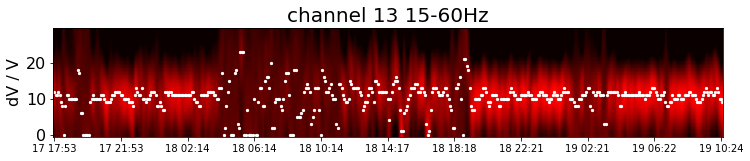

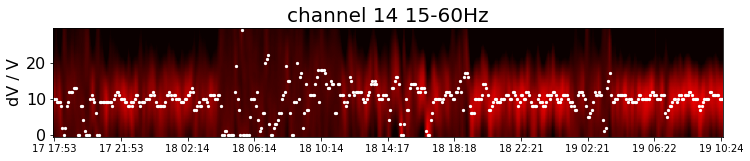

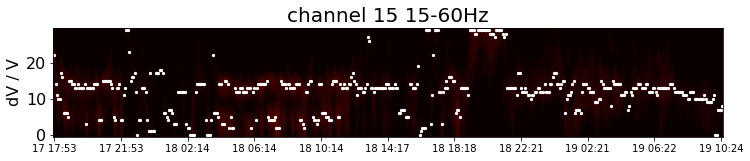

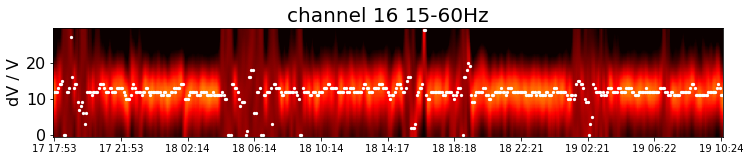

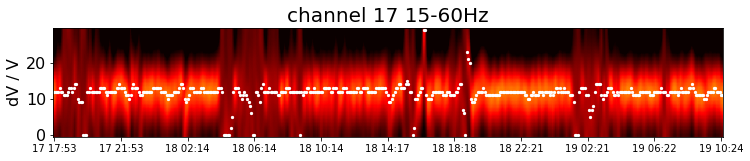

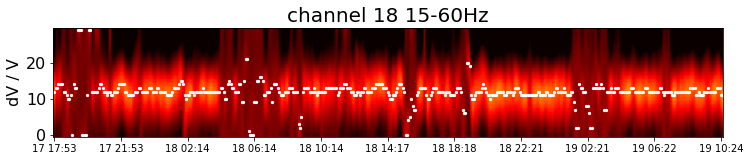

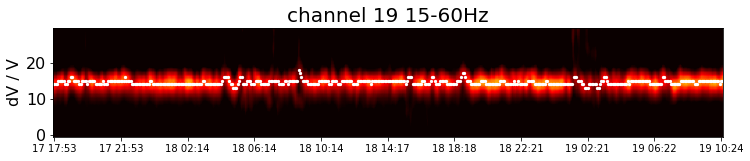

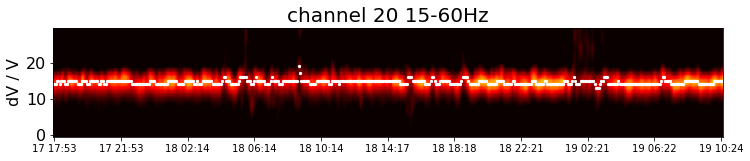

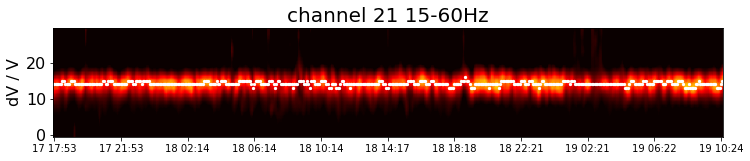

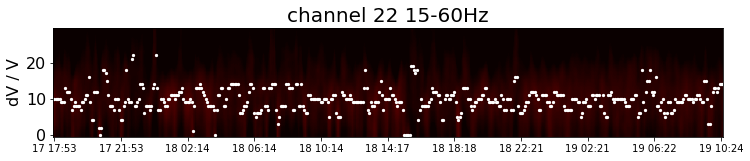

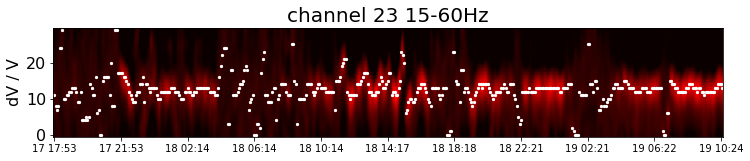

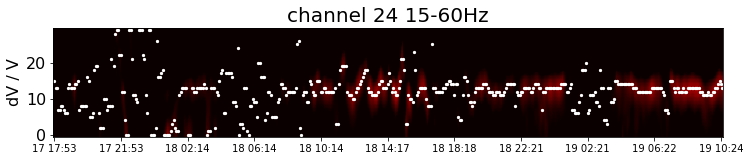

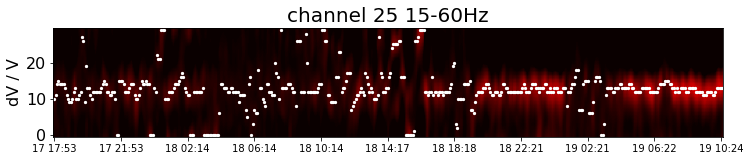

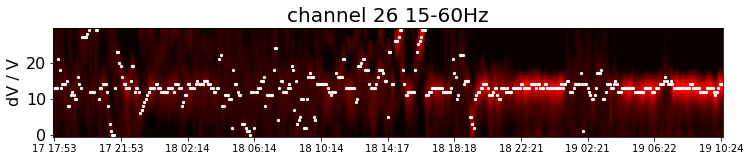

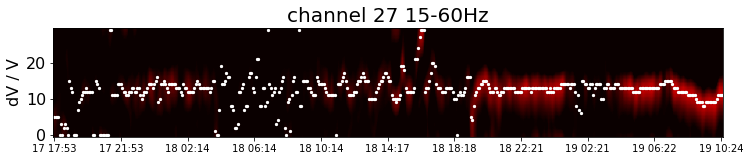

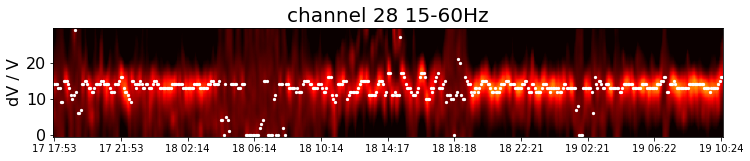

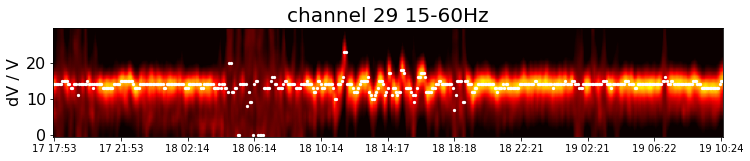

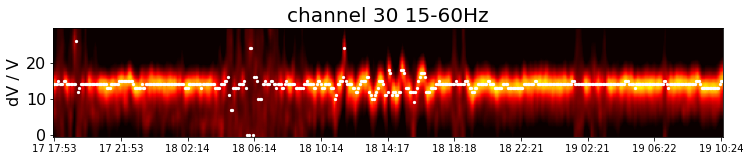

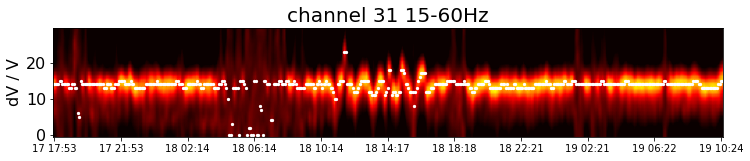

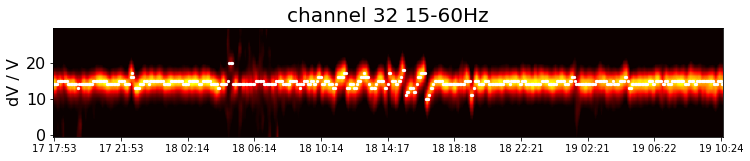

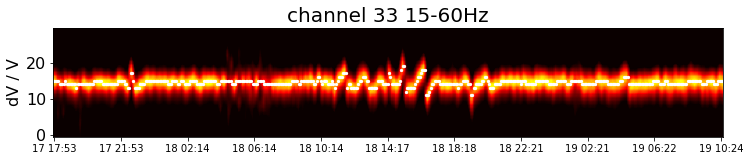

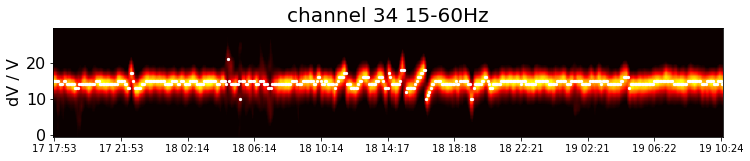

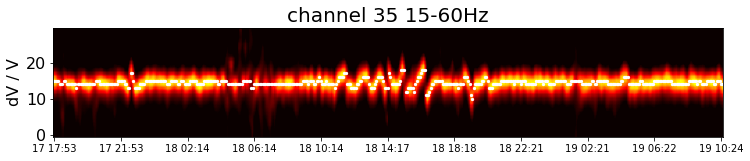

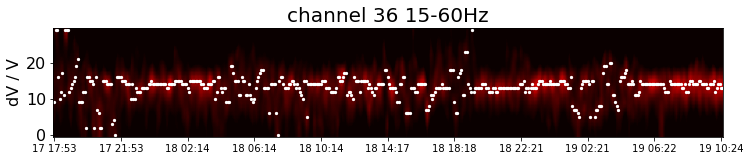

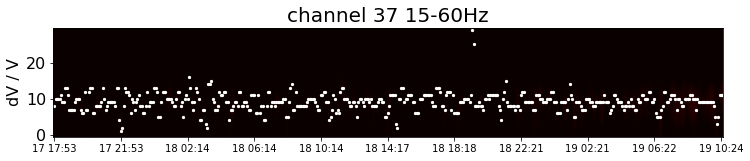

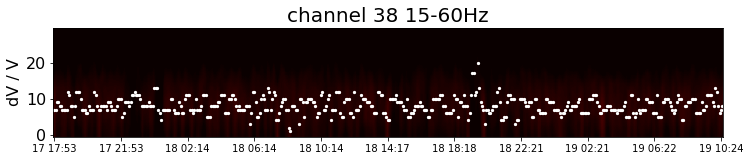

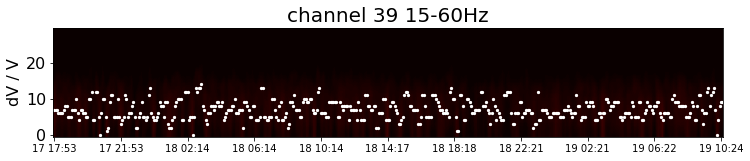

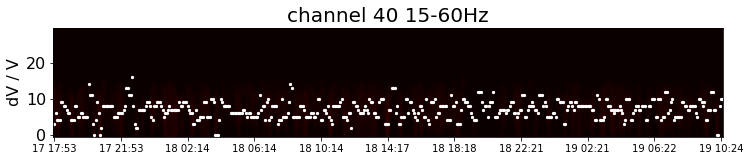

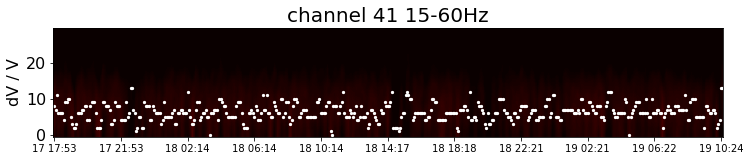

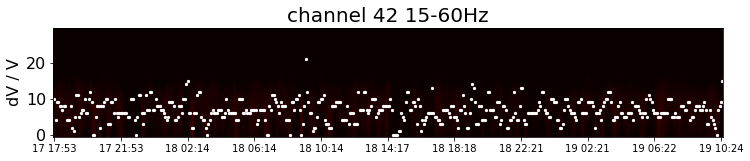

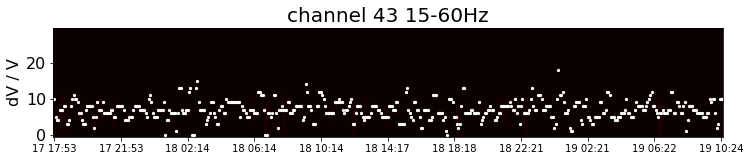

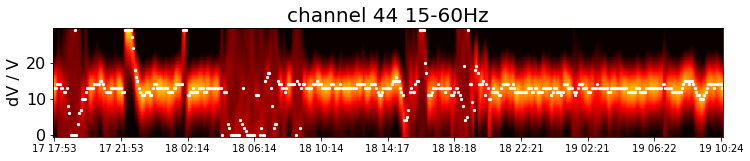

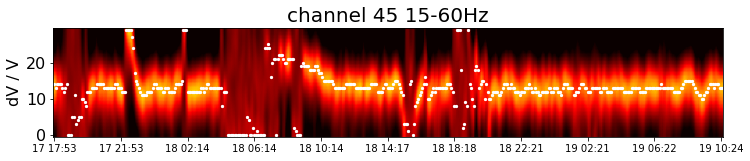

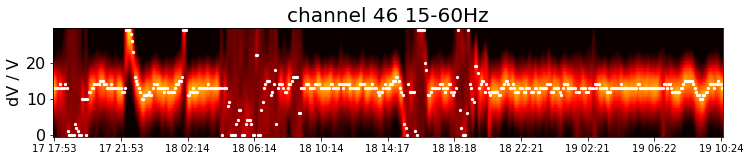

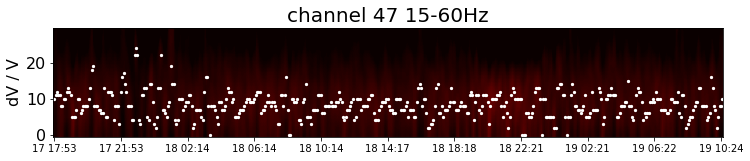

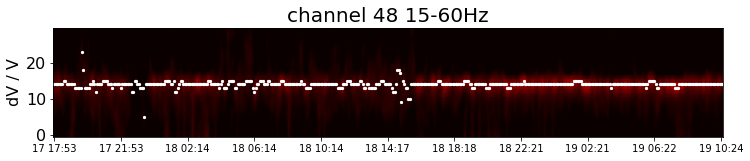

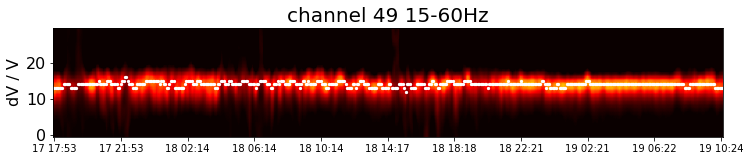

In [9]:
# 2D space time of dvv
time = y[win_st:] / samp_freq

all_dvv = np.zeros((50, len(x)), dtype = np.float32)
all_cc = np.zeros((50, len(stretch_range), len(x)), dtype = np.float32)

for iloc in range(50):
    data_plot=corr_all_time[iloc].T
    trunc_acf = data_plot[win_st:, :]
    trunc_stk = stack_stretch[iloc, :]/count
    strecthed_acfs = np.zeros_like(trunc_acf)
    for i in x:
        ratios, ccs = stretch_distribution(trunc_stk, trunc_acf[:,i], time, min_ratio=0.85, max_ratio=1.15)
        all_cc[iloc, :, i] = ccs 
        
    ######################
    ## Denoising
    # %% Use cone-filter
    filt_data, filtered_fk, fk2d = fk_filter_2cones(all_cc[iloc].T, w1=0.003, w2=0.005, cone1=True, cone2=False)
    image = filt_data.real.T[:,:]
    image = image - np.nanmin(image)
    denoised_image = gaussian_filter(image, sigma=1)
    #######################
    dvv_ind = np.argmax(denoised_image, axis=0)
    for i in range(len(dvv_ind)):
        all_dvv[iloc, i]= stretch_range[dvv_ind[i]]
    # cc_dvv = np.nanmax(denoised_image, axis=0)

    plt.figure(figsize = (12, 2))
    plt.imshow(denoised_image, aspect='auto', cmap='hot', vmin=0.2, vmax=1, origin='lower', interpolation=None)
    plt.scatter(np.arange(len(x)), dvv_ind, c='w', s=5)
    plt.xticks(xax, hrax, fontsize = 10)
    # plt.xlabel("Day Hour:Minute", fontsize = 16)
    plt.ylabel("dV / V", fontsize = 16)
    plt.title('channel '+ str(iloc)+ ' ' + str(freqmin)+'-'+str(freqmax)+'Hz', fontsize = 20)


# Enhancement

## Enhancement 2 --correlating dV/V with spectra, set multi-bounds, and remove outliers

In [39]:
### piece-wise linear interpolation (Nan You)
def peak_dvv(new_peaks, ax, thrs=0.3):

    ### interpolate to remove negative points
    f = interp1d(np.nonzero(new_peaks>0)[0], new_peaks[new_peaks>0], bounds_error=False, fill_value="extrapolate", kind='linear')
    new_peaks_iloc = f(np.arange(len(new_peaks)))

    ### subsegments based on gradient
    grad_iloc = np.abs(np.diff(new_peaks_iloc))
    ax.plot(x[1:], grad_iloc, 'purple')
    grad_peaks_iloc, _ = find_peaks(grad_iloc, height=5)
    grad_peaks_iloc += 1  ## shift to correct diff

    ### Each segment
    preserve_inds = [np.arange(50, 60), np.arange(201, 299)]
    for (ini, iend) in [[0, 50], [60, 201], [299, len(new_peaks_iloc)]]:

        ### find sub-segments in each segment
        split_pts = grad_peaks_iloc[(grad_peaks_iloc > ini) & (grad_peaks_iloc < iend)]-ini
        if len(split_pts) <= 1:
            preserve_inds.append(np.arange(ini, iend))
            continue
        ### split sub-segments
        data_segs = np.split(new_peaks_iloc[ini:iend], split_pts)
        ind_segs = np.split(np.arange(ini, iend), split_pts)
        ### find longest sub-segment
        ref_seg_id = np.argmax([len(seg) for seg in data_segs])
        mean_segs = np.array([np.mean(seg) for seg in data_segs])
        preserve_seg_id = [ref_seg_id]

        num_iter = 0
        while True:
            
            ### fit a line to selected sub-segments
            coefficients = np.polyfit(np.hstack([ind_segs[i] for i in preserve_seg_id]), 
                np.hstack([data_segs[i] for i in preserve_seg_id]), 1)
            polynomial = np.poly1d(coefficients)

            ### calculate distance between all sub-segments and the line
            mean_distance = np.array([np.sqrt(np.mean(np.square(polynomial(ind_segs[i])-data_segs[i]))) for i in range(len(data_segs))])

            # collect sub-segments for merging
            if num_iter == 0:
                combine_ids = np.argsort(mean_distance)[:2]
            else:
                combine_ids = np.nonzero(mean_distance < thrs * (np.amax(mean_segs)-np.amin(mean_segs)))[0]
            if len(combine_ids) == len(preserve_seg_id) or len(combine_ids) == 0:
                break
            preserve_seg_id = combine_ids
            num_iter += 1

        preserve_inds.extend([ind_segs[i] for i in preserve_seg_id])
        
    ### take all selected sub-segments of all segments
    preserve_inds = np.hstack(preserve_inds)
    f = interp1d(preserve_inds, new_peaks_iloc[preserve_inds], bounds_error=False, fill_value="extrapolate", kind='linear')
    new_peaks_iloc[:] = f(np.arange(len(new_peaks_iloc)))
    
    ax.plot(x, new_peaks_iloc, 'g')

    return new_peaks_iloc

In [11]:

threshold_all = [
    [0,  0.5, 3], [1,  0.5, 3], [2,  0.5, 3], [3,  0.5, 3], [4,  0.5, 3], [5,  0.5, 3], [6,  0.5, 3], [7,  0.5, 3], [8,  0.5, 3], [9,  0.5, 3],
    [10, 0.5, 3], [11, 0.5, 3], [12, 0.5, 3], [13, 0.5, 3], [14, 0.5, 5], [15, 0.5, 5], [16, 0.5, 3], [17, 0.5, 3], [18, 0.5, 3], [19, 0.5, 3], 
    [20, 0.5, 3], [21, 0.5, 3], [22, 0.5, 3], [23, 0.5, 4], [24, 0.5, 4], [25, 0.5, 4], [26, 0.5, 3], [27, 0.5, 3], [28, 0.5, 3], [29, 0.5, 3],
    [30, 0.5, 3], [31, 0.5, 3], [32, 0.5, 3], [33, 0.5, 3], [34, 0.5, 3], [35, 0.5, 3], [36, 0.5, 3], [37, 0.5, 3], [38, 0.5, 3], [39, 0.5, 3], 
    [40, 0.5, 3], [41, 0.5, 3], [42, 0.5, 3], [43, 0.5, 3], [44, 0.5, 4], [45, 0.5, 5], [46, 0.5, 4], [47, 0.5, 3], [48, 0.5, 3], [49, 0.5, 3]
]

nfft, time_width = calc_NFFT(full_time_data[33], sample_rate, power_of_2=True)
print(f'saturated for period > {time_width/2} seconds')

NFFT=8192 samples, equivalent to 81.92 seconds
saturated for period > 40.96 seconds


30


 40%|████      | 20/50 [02:47<04:28,  8.94s/it]<ipython-input-42-14801662b490>:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figg, axx = plt.subplots(1,2, figsize=(12, 2))
100%|██████████| 50/50 [06:59<00:00,  8.40s/it]


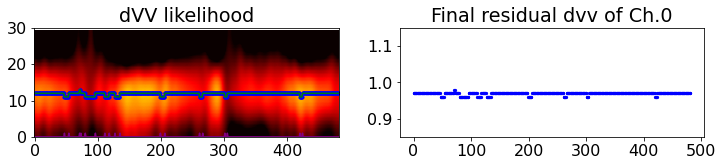

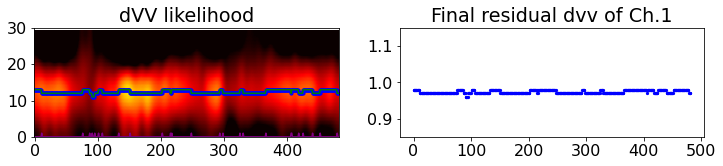

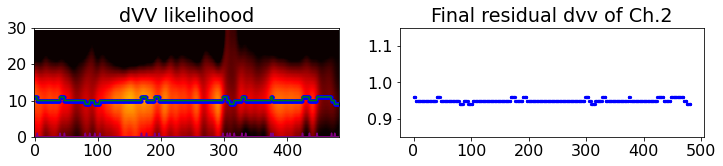

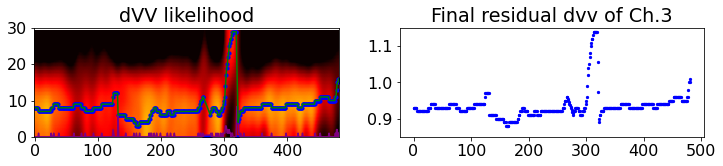

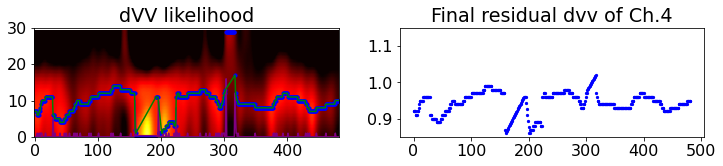

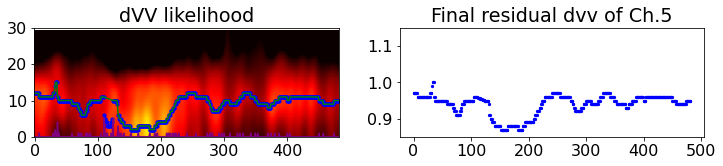

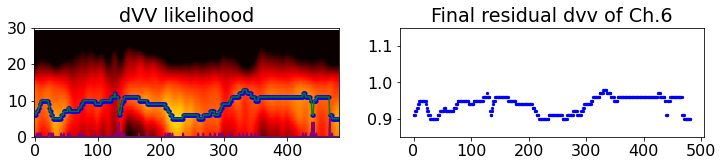

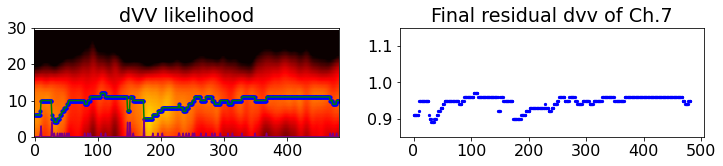

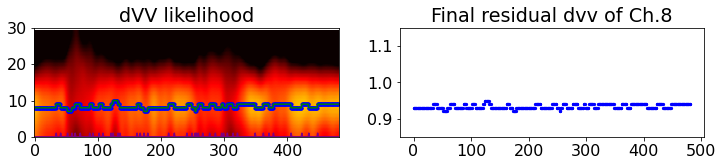

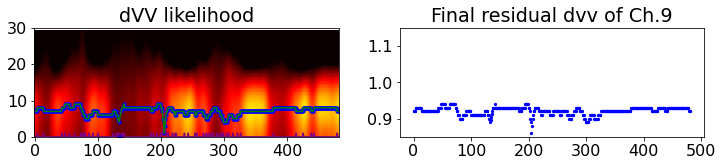

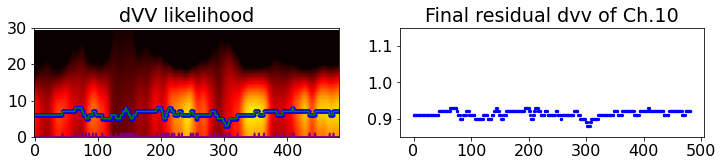

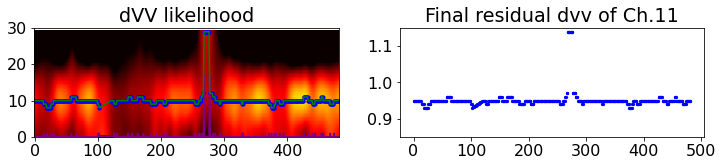

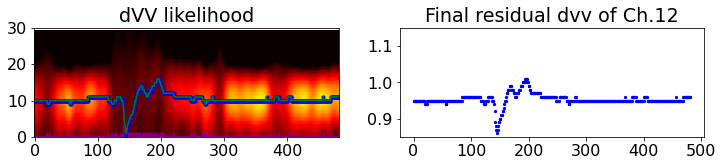

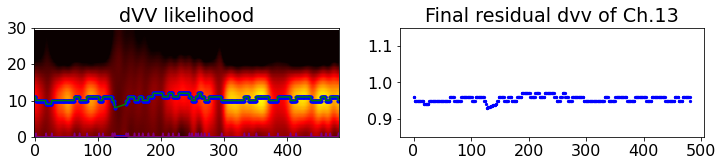

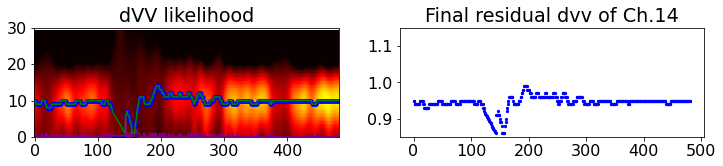

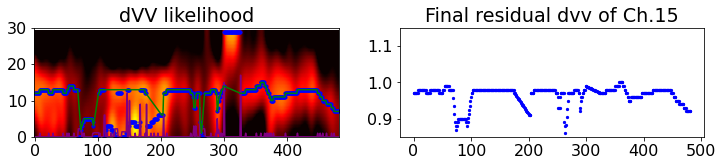

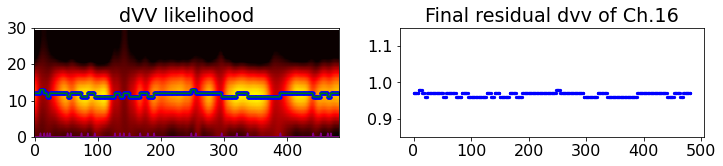

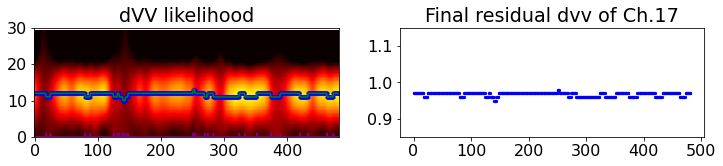

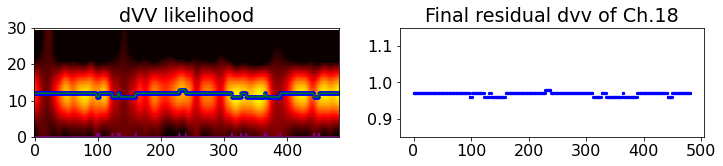

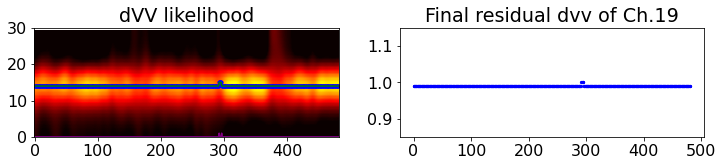

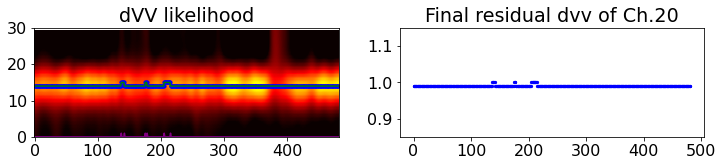

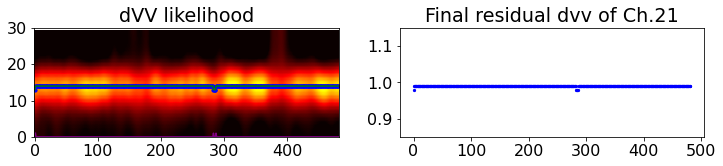

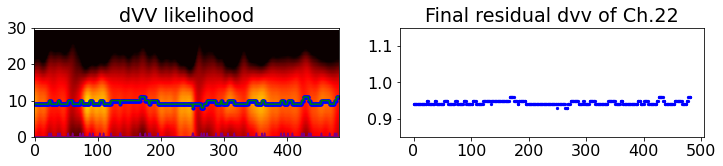

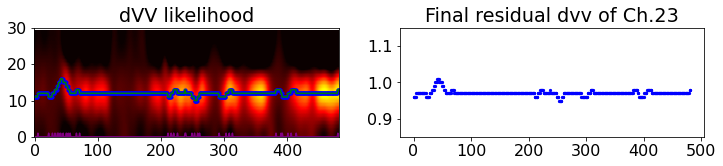

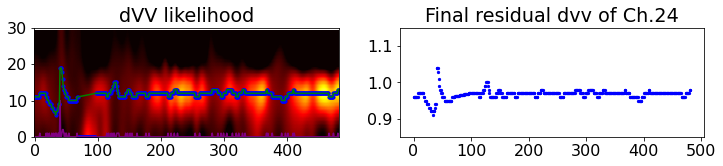

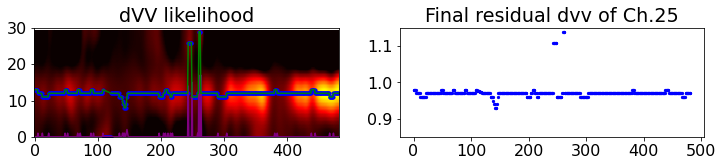

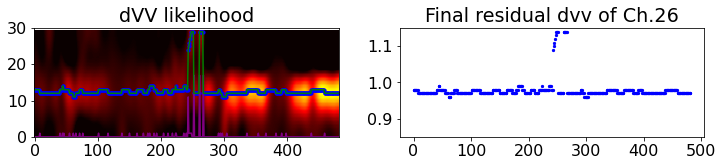

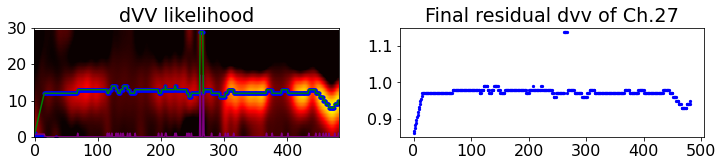

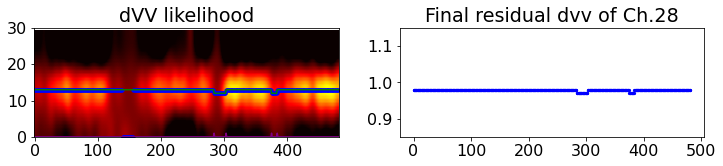

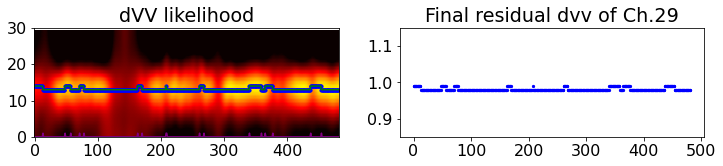

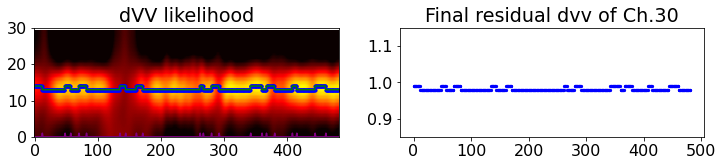

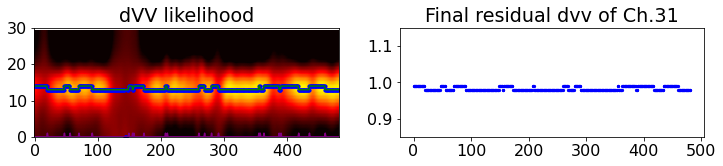

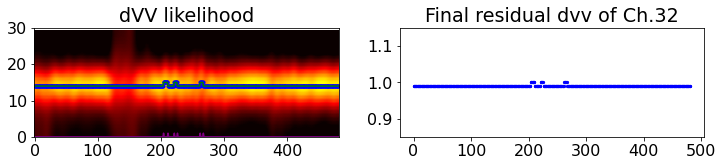

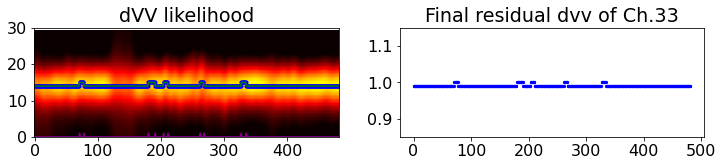

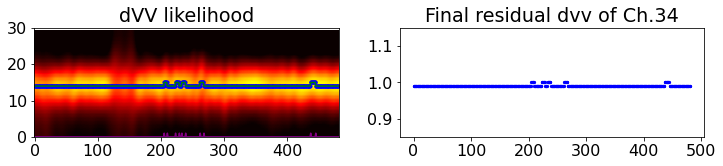

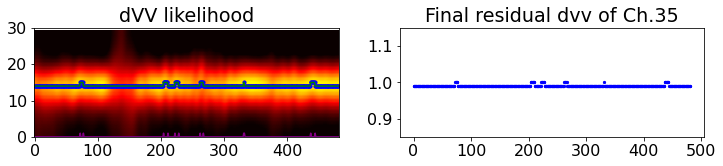

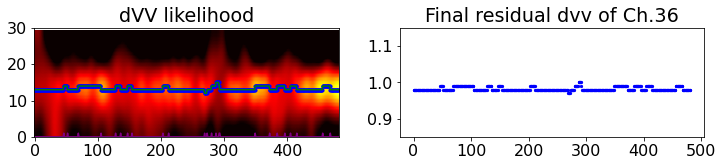

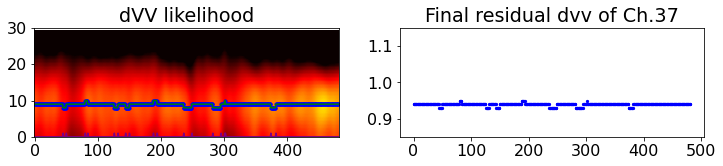

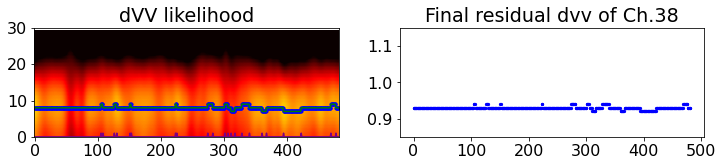

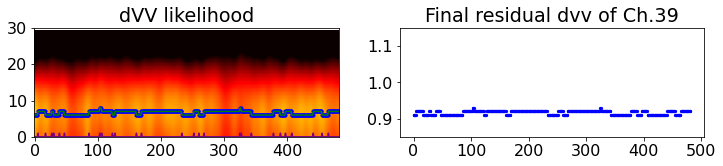

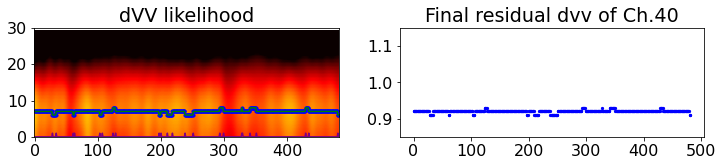

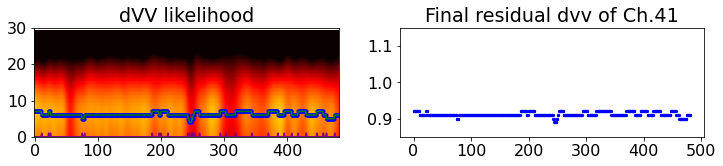

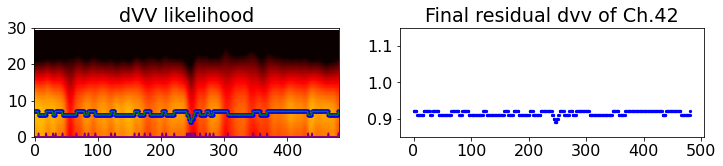

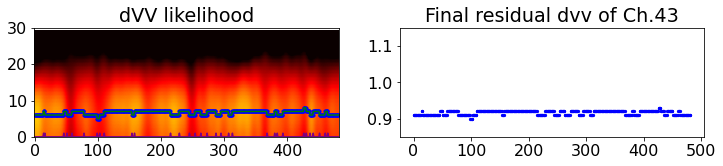

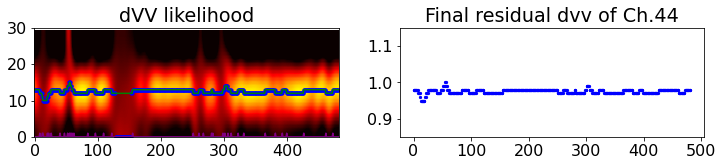

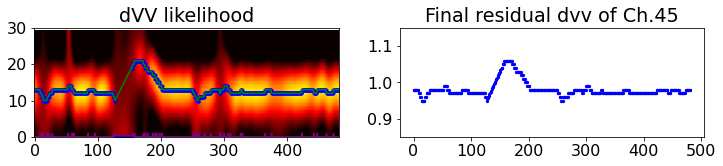

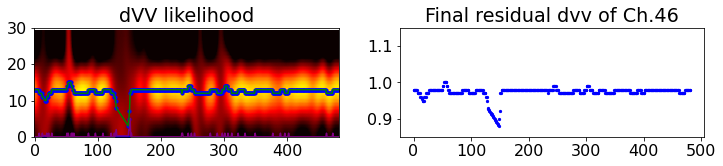

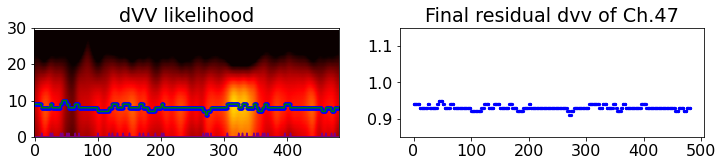

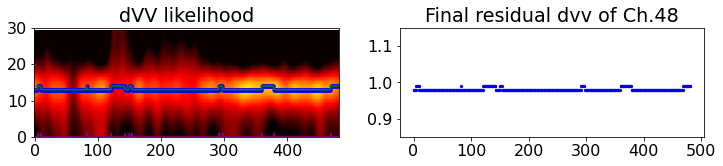

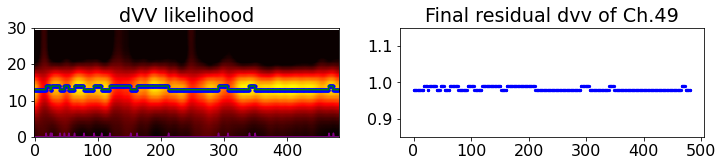

In [42]:
time = y[win_st:] / samp_freq
x=np.arange(corr_all_time.shape[1])
new_cc = np.zeros((50, 30, len(x)), dtype = np.float32)
cc_dvv = np.zeros((50, len(x)), dtype = np.float32)
new_peaks = np.zeros((50, len(x)), dtype=np.float32)
final_peaks = np.zeros((50, len(x)), dtype=np.float32)
stretch_range = np.arange(0.85, 1.15, 0.01)
print(len(stretch_range))

for iloc, _, _ in tqdm(threshold_all[0:50:1]):

    denoise_it = 3
    thrshold = 0.5
    ######################  Prepare dvv likelihood
    ## slice ACF for a channel, roughly a plot
    data_plot=corr_all_time[iloc].T  # shape (corr lag time, time window number)
    trunc_acf = data_plot[win_st:, :]  # cut out primary phase for stretching
    trunc_stk = stack_stretch[iloc, :] / count  # Reference stack ACF
    
    for i in x:  ## stretch for dvv likelihood
        ratios, ccs = stretch_distribution(trunc_stk, trunc_acf[:,i], time, min_ratio=0.85, max_ratio=1.15)
        new_cc[iloc, :, i] = ccs 
        
    ## Denoise dvv likelihood
    for i in range(denoise_it):
        filt_data, filtered_fk, fk2d = fk_filter_2cones(new_cc[iloc].T, w1=0.001*(i+1), w2=0.005, cone1=True, cone2=False)
        image = filt_data.real.T[:,:]  # only real part
        dvv_image = gaussian_filter(image, sigma=(i+1, 2*i+1))
    dvv_image = dvv_image / np.std(dvv_image)


    ############ plot
    figg, axx = plt.subplots(1,2, figsize=(12, 2))

    axx[0].set_ylim(0, len(stretch_range))

    q1=np.percentile(dvv_image, q=25)
    q2=np.percentile(dvv_image, q=99) * 1.5
    axx[0].imshow(dvv_image, vmin=q1, vmax=q2, cmap='hot',aspect='auto', origin='lower')
    axx[0].set_title('dVV likelihood')
    peak_values = np.argmax(dvv_image, axis=0)
    axx[0].scatter(x, peak_values, marker='o', c='blue', s=10)
    peak_values_raw = peak_dvv(peak_values, axx[0], thrs=thrshold)

    final_peaks[iloc] = peak_values_raw * 0.01 + 0.85
    axx[1].set_title('Final residual dvv of Ch.'+str(iloc))

    axx[1].scatter(x, final_peaks[iloc], marker='o', c='blue', s=5)
    axx[1].set_ylim(0.85, 1.15)


## Saving clean dV/V

In [43]:
with h5py.File('data/final_peaks_15_60Hz_3rd_iteration.h5', 'w') as f:
    f.create_dataset('final_peaks', data=final_peaks)
